<a href="https://colab.research.google.com/github/shravn-10/Dengue_fyp/blob/main/ARIMA_%26_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Processing and ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Advanced Modeling Libraries
import catboost as cb
import optuna

class AdvancedTimeSeriesPredictor:
    def __init__(self, csv_path):
        """
        Comprehensive time series prediction model

        Parameters:
        -----------
        csv_path : str
            Path to the input CSV file
        """
        self.csv_path = csv_path
        self.model = None
        self.scaler = None
        self.feature_importances = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None

    def load_and_preprocess_data(self):
        """
        Enhanced data loading and preprocessing with comprehensive feature engineering

        Returns:
        --------
        X : pd.DataFrame
            Preprocessed feature matrix
        y : pd.Series
            Target variable
        """
        # Load data
        df = pd.read_csv(self.csv_path)

        # Comprehensive month mapping
        month_map = {
            'jan': 1, 'january': 1, 'feb': 2, 'february': 2,
            'mar': 3, 'march': 3, 'apr': 4, 'april': 4,
            'may': 5, 'jun': 6, 'june': 6, 'jul': 7, 'july': 7,
            'aug': 8, 'august': 8, 'sep': 9, 'sept': 9, 'september': 9,
            'oct': 10, 'october': 10, 'nov': 11, 'november': 11,
            'dec': 12, 'december': 12
        }

        # Convert month to numeric
        df['month'] = df['month'].str.lower().map(month_map)

        # Advanced feature engineering
        weather_cols = ['max_temp', 'min_temp', 'avg_temp', 'avg_humidity',
                        'avg_precip', 'avg_windspeed', 'avg_cloudcover']

        # Lag and rolling features
        for col in weather_cols:
            # Multiple lag features
            for lag in [1, 2, 3, 7, 14]:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)

            # Rolling window features
            for window in [3, 7, 14]:
                df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
                df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()

        # Advanced cyclical encoding for month
        df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
        df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))

        # Advanced interaction features
        df['temp_humidity_interaction'] = df['avg_temp'] * df['avg_humidity']
        df['precip_windspeed_interaction'] = df['avg_precip'] * df['avg_windspeed']

        # Exponential weighted moving average
        for col in weather_cols:
            df[f'{col}_ewma'] = df[col].ewm(span=7, adjust=False).mean()

        # Rate of change features
        for col in weather_cols:
            df[f'{col}_roc'] = df[col].pct_change()

        # Polynomial interaction terms
        poly_cols = ['avg_temp', 'avg_humidity', 'avg_precip']
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(df[poly_cols])
        poly_feature_names = poly.get_feature_names_out(poly_cols)
        poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
        df = pd.concat([df, poly_df], axis=1)

        # Replace infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Drop rows with missing values
        df.dropna(inplace=True)

        # Separate features and target
        feature_cols = [col for col in df.columns if col not in ['area', 'year', 'positives']]
        X = df[feature_cols]
        y = df['positives']

        return X, y

    def feature_importance_selection(self, X, y, top_n=25):
        """
        Advanced feature selection using mutual information

        Parameters:
        -----------
        X : pd.DataFrame
            Feature matrix
        y : pd.Series
            Target variable
        top_n : int, optional
            Number of top features to select

        Returns:
        --------
        list
            Top selected feature names
        """
        selector = SelectKBest(score_func=mutual_info_regression, k=top_n)
        selector.fit(X, y)
        top_feature_indices = selector.get_support(indices=True)
        return X.columns[top_feature_indices].tolist()

    def objective(self, trial):
        """
        Optuna objective function for hyperparameter optimization

        Parameters:
        -----------
        trial : optuna.Trial
            Optuna trial object for hyperparameter tuning

        Returns:
        --------
        float
            Mean cross-validation score
        """
        params = {
            'iterations': trial.suggest_int('iterations', 100, 2000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'random_strength': trial.suggest_uniform('random_strength', 0.5, 2.0),
            'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0)
        }

        model = cb.CatBoostRegressor(**params,
                                     loss_function='RMSE',
                                     verbose=0,
                                     random_seed=42)

        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = []

        for train_index, test_index in tscv.split(self.X_train_scaled):
            X_train_fold = self.X_train_scaled[train_index]
            y_train_fold = self.y_train.iloc[train_index]
            X_val_fold = self.X_train_scaled[test_index]
            y_val_fold = self.y_train.iloc[test_index]

            model.fit(X_train_fold, y_train_fold,
                      eval_set=(X_val_fold, y_val_fold),
                      early_stopping_rounds=50)

            y_pred = model.predict(X_val_fold)
            cv_scores.append(mean_squared_error(y_val_fold, y_pred, squared=False))

        return np.mean(cv_scores)

    def train_and_evaluate(self, test_size=0.2):
        """
        Comprehensive model training and evaluation

        Parameters:
        -----------
        test_size : float, optional
            Proportion of the dataset to include in the test split

        Returns:
        --------
        tuple
            Model performance metrics
        """
        # Load and preprocess data
        X, y = self.load_and_preprocess_data()

        # Feature selection
        top_features = self.feature_importance_selection(X, y)
        X = X[top_features]

        # Split data with time series consideration
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False
        )

        # Scale features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Hyperparameter optimization
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=200)

        # Best hyperparameters
        best_params = study.best_params
        print("\nBest Hyperparameters:", best_params)

        # Final model with best hyperparameters
        self.model = cb.CatBoostRegressor(
            **best_params,
            loss_function='RMSE',
            verbose=0,
            random_seed=42
        )

        # Fit the model with early stopping
        self.model.fit(
            self.X_train_scaled,
            self.y_train,
            eval_set=(self.X_test_scaled, self.y_test),
            early_stopping_rounds=50
        )

        # Predictions
        y_pred = self.model.predict(self.X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        print("\nCatBoost Performance Metrics:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R2 Score: {r2:.4f}")

        # Feature importance
        self.feature_importances = pd.DataFrame({
            'feature': top_features,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(self.feature_importances.head(10))

        return self.model, self.scaler, (rmse, mae, r2), self.feature_importances

# Example usage
if __name__ == "__main__":
    csv_path = "dataset_of_bengaluru.csv"  # Replace with your CSV file path
    predictor = AdvancedTimeSeriesPredictor(csv_path)
    model, scaler, metrics, feature_importance = predictor.train_and_evaluate()
    rmse, mae, r2 = metrics

[I 2024-12-09 09:44:36,518] A new study created in memory with name: no-name-4f9370a8-3675-42d8-a5ce-bec81aae6a38
[I 2024-12-09 09:44:49,162] Trial 0 finished with value: 584.560907704347 and parameters: {'iterations': 290, 'depth': 7, 'learning_rate': 0.015937829199768706, 'random_strength': 0.9301557872041215, 'bagging_temperature': 0.21893589992424844, 'l2_leaf_reg': 78.90050482578279}. Best is trial 0 with value: 584.560907704347.
[I 2024-12-09 09:44:53,235] Trial 1 finished with value: 65.81944021994347 and parameters: {'iterations': 140, 'depth': 8, 'learning_rate': 0.2851245871240752, 'random_strength': 1.9476249581104077, 'bagging_temperature': 0.7143472198992328, 'l2_leaf_reg': 2.478897096359041e-06}. Best is trial 1 with value: 65.81944021994347.
[I 2024-12-09 09:45:19,411] Trial 2 finished with value: 32.4067938525828 and parameters: {'iterations': 774, 'depth': 9, 'learning_rate': 0.01589049132370107, 'random_strength': 0.6504251755398023, 'bagging_temperature': 0.101903249


Best Hyperparameters: {'iterations': 411, 'depth': 7, 'learning_rate': 0.018849023962403594, 'random_strength': 0.5177936934873123, 'bagging_temperature': 0.26198377202072537, 'l2_leaf_reg': 1.4508434410135836e-08}

CatBoost Performance Metrics:
RMSE: 1280.20
MAE: 692.33
R2 Score: 0.2360


ValueError: All arrays must be of the same length

Model Evaluation Results:
       Order Seasonal Order          AIC          MSE       RMSE        MAE  \
0  (1, 1, 1)  (1, 1, 1, 12)  1283.763136  1172.457847  34.241172  27.138655   
3  (2, 1, 1)  (1, 1, 1, 12)  1284.234229  1174.713708  34.274097  27.451995   
2  (1, 1, 0)  (1, 1, 1, 12)  1315.053182  1609.674985  40.120755  33.099362   
1  (0, 1, 1)  (1, 1, 0, 12)  1314.639521  1831.700815  42.798374  35.117258   

    MAPE (%)  R2 Score  
0  25.305456  0.807498  
3  25.549396  0.807128  
2  37.978432  0.735713  
1  35.092739  0.699259  

Best Model Parameters:
Order                 (1, 1, 1)
Seasonal Order    (1, 1, 1, 12)
AIC                 1283.763136
MSE                 1172.457847
RMSE                  34.241172
MAE                   27.138655
MAPE (%)              25.305456
R2 Score               0.807498
Name: 0, dtype: object


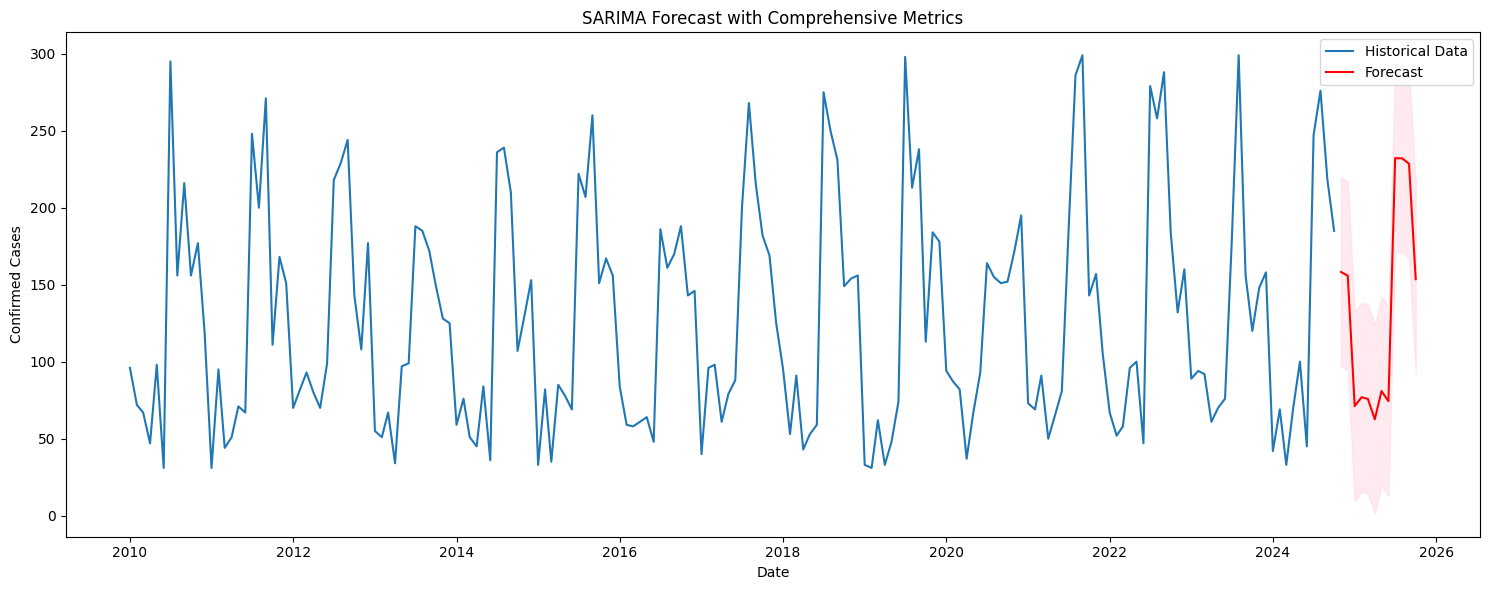


Detailed Forecast for Next 12 Months:
2024-11-01    158.278937
2024-12-01    155.831629
2025-01-01     71.185472
2025-02-01     76.956606
2025-03-01     75.816896
2025-04-01     62.580472
2025-05-01     80.937078
2025-06-01     74.353019
2025-07-01    232.174023
2025-08-01    232.065271
2025-09-01    228.568025
2025-10-01    153.582266
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/content/Manually edited file.csv')
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
df.set_index('Date', inplace=True)
cases_series = df['Confirmed Cases']

# Split data into train and test
train_size = int(len(cases_series) * 0.8)
train, test = cases_series[:train_size], cases_series[train_size:]

def comprehensive_sarima_evaluation(train, test):
    # Parameter grid for comprehensive search
    param_grid = [
        ((1,1,1), (1,1,1,12)),
        ((0,1,1), (1,1,0,12)),
        ((1,1,0), (1,1,1,12)),
        ((2,1,1), (1,1,1,12))
    ]

    results = []

    for order, seasonal_order in param_grid:
        try:
            # Fit SARIMA model
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=seasonal_order)
            results_model = model.fit(disp=False)

            # Forecast on test set
            forecast = results_model.get_forecast(steps=len(test))
            forecast_mean = forecast.predicted_mean

            # Compute comprehensive metrics
            mse = mean_squared_error(test, forecast_mean)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test, forecast_mean)
            mape = mean_absolute_percentage_error(test, forecast_mean)
            r2 = r2_score(test, forecast_mean)

            results.append({
                'Order': order,
                'Seasonal Order': seasonal_order,
                'AIC': results_model.aic,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE (%)': mape * 100,
                'R2 Score': r2
            })
        except Exception as e:
            print(f"Error with {order}, {seasonal_order}: {e}")

    # Convert to DataFrame and sort by multiple criteria
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['RMSE', 'MAE', 'AIC'])

    return results_df

# Evaluate models
evaluation_results = comprehensive_sarima_evaluation(train, test)
print("Model Evaluation Results:")
print(evaluation_results)

# Select best model based on lowest RMSE and AIC
best_model_params = evaluation_results.iloc[0]
print("\nBest Model Parameters:")
print(best_model_params)

# Fit best model on full dataset and forecast
best_model = SARIMAX(cases_series,
                     order=tuple(best_model_params['Order']),
                     seasonal_order=tuple(best_model_params['Seasonal Order'])).fit(disp=False)

# Forecast next 12 months
forecast = best_model.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(cases_series.index, cases_series.values, label='Historical Data')
plt.plot(forecast_mean.index, forecast_mean.values, color='red', label='Forecast')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('SARIMA Forecast with Comprehensive Metrics')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.tight_layout()
plt.show()

# Detailed Forecast
print("\nDetailed Forecast for Next 12 Months:")
print(forecast_mean)

ARIMA Model Evaluation Results:
  Order (p,d,q)          AIC          BIC          MSE       RMSE        MAE  \
0     (0, 1, 0)  1599.431491  1602.380251  6179.305556  78.608559  67.527778   
4     (2, 1, 1)  1594.111450  1605.906489  7163.379974  84.636753  74.575071   
3     (1, 1, 1)  1592.116527  1600.962807  7210.072692  84.912147  74.880878   
1     (1, 1, 0)  1591.260318  1597.157838  7890.205387  88.826828  78.806889   
2     (0, 1, 1)  1592.388117  1598.285637  8170.149455  90.388879  80.120308   
5     (1, 2, 1)  1588.381068  1597.205995  8838.326439  94.012374  83.571868   

     MAPE (%)  R2 Score  
0   76.723555 -0.014559  
4   93.974912 -0.176131  
3   94.556812 -0.183797  
1  101.964632 -0.295466  
2  104.584600 -0.341429  
5  110.975153 -0.451135  

Best ARIMA Model Parameters:
Order (p,d,q)      (0, 1, 0)
AIC              1599.431491
BIC              1602.380251
MSE              6179.305556
RMSE               78.608559
MAE                67.527778
MAPE (%)           76

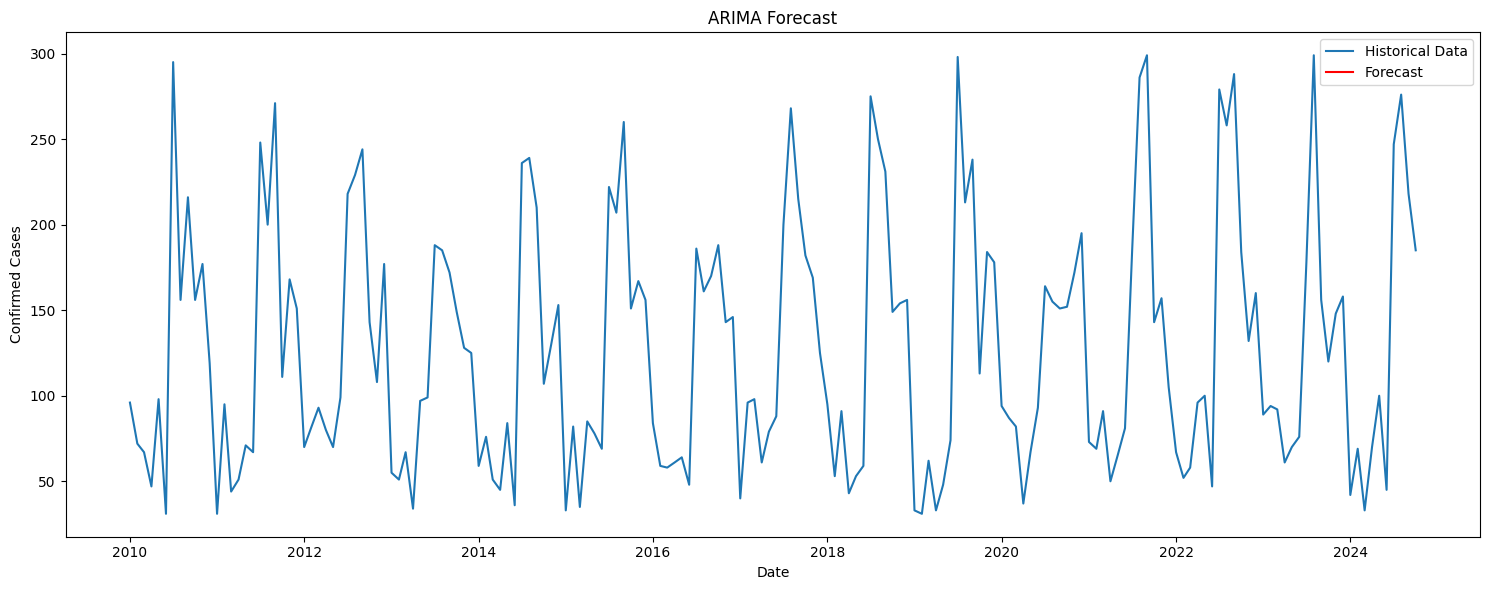

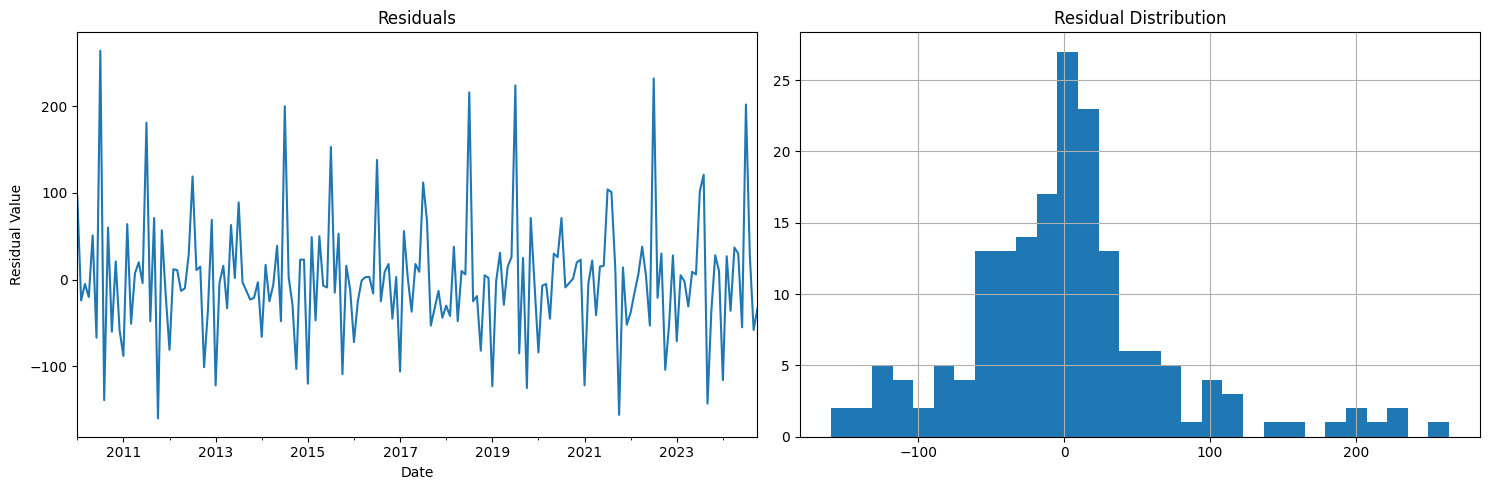


Detailed Forecast for Next 12 Months:
2024-11-30   NaN
2024-12-31   NaN
2025-01-31   NaN
2025-02-28   NaN
2025-03-31   NaN
2025-04-30   NaN
2025-05-31   NaN
2025-06-30   NaN
2025-07-31   NaN
2025-08-31   NaN
2025-09-30   NaN
2025-10-31   NaN
Freq: ME, Name: predicted_mean, dtype: float64

Model Diagnostic Information:
                               SARIMAX Results                                
Dep. Variable:        Confirmed Cases   No. Observations:                  178
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1005.034
Date:                Tue, 10 Dec 2024   AIC                           2012.068
Time:                        04:16:37   BIC                           2015.244
Sample:                    01-01-2010   HQIC                          2013.356
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/content/Manually edited file.csv')
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
df.set_index('Date', inplace=True)
cases_series = df['Confirmed Cases']

# Split data into train and test
train_size = int(len(cases_series) * 0.8)
train, test = cases_series[:train_size], cases_series[train_size:]

def comprehensive_arima_evaluation(train, test):
    # Parameter grid for comprehensive search
    param_grid = [
        (0,1,0),
        (1,1,0),
        (0,1,1),
        (1,1,1),
        (2,1,1),
        (1,2,1)
    ]

    results = []

    for order in param_grid:
        try:
            # Fit ARIMA model
            model = ARIMA(train, order=order)
            results_model = model.fit()

            # Forecast on test set
            forecast = results_model.forecast(steps=len(test))

            # Compute comprehensive metrics
            mse = mean_squared_error(test, forecast)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test, forecast)
            mape = mean_absolute_percentage_error(test, forecast)
            r2 = r2_score(test, forecast)

            results.append({
                'Order (p,d,q)': order,
                'AIC': results_model.aic,
                'BIC': results_model.bic,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE (%)': mape * 100,
                'R2 Score': r2
            })
        except Exception as e:
            print(f"Error with {order}: {e}")

    # Convert to DataFrame and sort by multiple criteria
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['RMSE', 'MAE', 'AIC'])

    return results_df

# Evaluate models
evaluation_results = comprehensive_arima_evaluation(train, test)
print("ARIMA Model Evaluation Results:")
print(evaluation_results)

# Select best model based on lowest RMSE and AIC
best_model_params = evaluation_results.iloc[0]
print("\nBest ARIMA Model Parameters:")
print(best_model_params)

# Fit best model on full dataset and forecast
best_order = tuple(best_model_params['Order (p,d,q)'])
best_model = ARIMA(cases_series, order=best_order).fit()

# Forecast next 12 months
forecast = best_model.forecast(steps=12)
forecast_series = pd.Series(forecast, index=pd.date_range(start=cases_series.index[-1], periods=13, freq='M')[1:])

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(cases_series.index, cases_series.values, label='Historical Data')
plt.plot(forecast_series.index, forecast_series.values, color='red', label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.tight_layout()
plt.show()

# Diagnostic Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Residual Plot
best_model.resid.plot(ax=ax1, title='Residuals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Residual Value')

# Residual Distribution
best_model.resid.hist(ax=ax2, bins=30)
ax2.set_title('Residual Distribution')
plt.tight_layout()
plt.show()

# Detailed Forecast
print("\nDetailed Forecast for Next 12 Months:")
print(forecast_series)

# Additional Model Diagnostics
print("\nModel Diagnostic Information:")
print(best_model.summary())

ARIMA Model Evaluation Results:
   Order (p,d,q)          AIC          BIC          MSE       RMSE        MAE  \
14     (2, 0, 2)  1489.615239  1507.350201  2351.135038  48.488504  37.790992   
0      (0, 0, 0)  1616.910576  1622.822230  6150.949491  78.427989  65.007433   
6      (1, 0, 0)  1574.973573  1583.841054  6159.385691  78.481754  65.015704   
7      (1, 0, 1)  1576.945049  1588.768357  6162.980222  78.504651  65.033344   
12     (2, 0, 0)  1576.907767  1588.731075  6167.790726  78.535283  65.053990   
1      (0, 0, 1)  1588.405506  1597.272987  6174.018085  78.574920  65.310982   
13     (2, 0, 1)  1576.847600  1591.626735  6176.316586  78.589545  64.911242   
3      (0, 1, 0)  1599.431491  1602.380251  6179.305556  78.608559  67.527778   
2      (0, 0, 2)  1562.910756  1574.734064  6184.174162  78.639520  65.463972   
17     (2, 1, 2)  1567.818492  1582.562292  6196.528023  78.718029  64.396578   
8      (1, 0, 2)  1582.295626  1597.074762  6199.263364  78.735401  63.508204

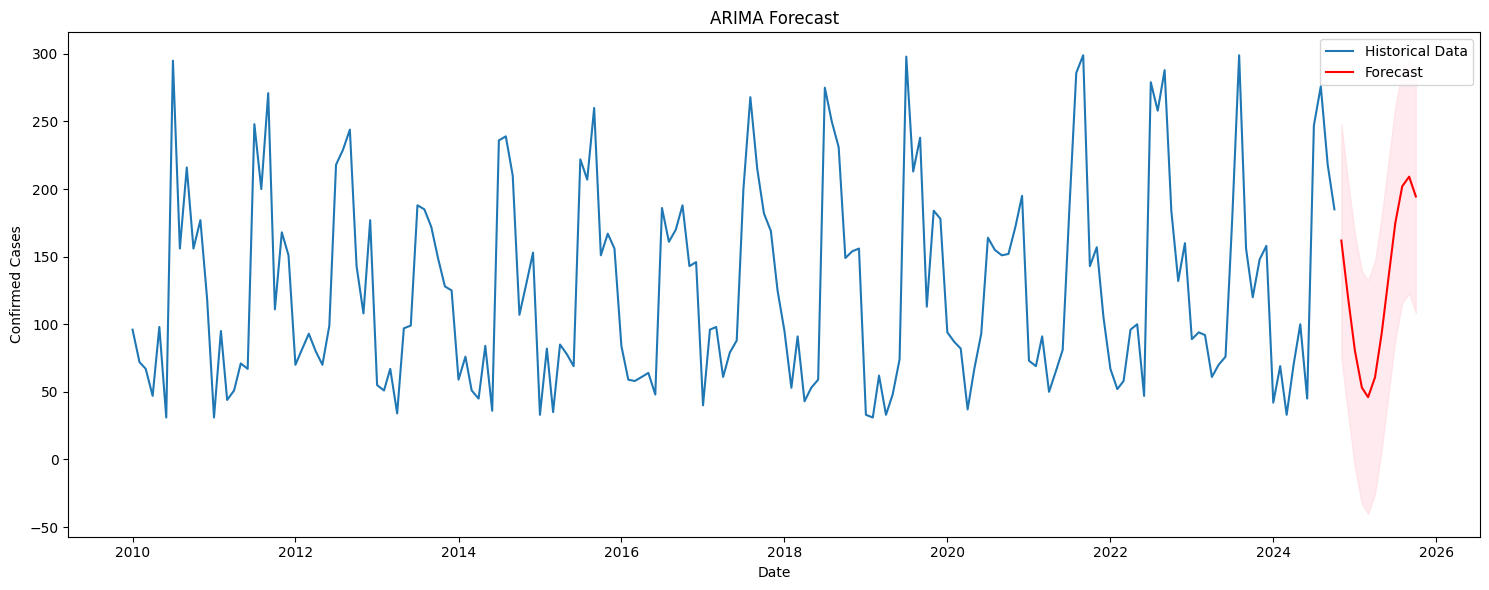


Detailed Forecast for Next 12 Months:
2024-11-01    161.927536
2024-12-01    120.117895
2025-01-01     80.321127
2025-02-01     53.201109
2025-03-01     46.024128
2025-04-01     60.712022
2025-05-01     93.327551
2025-06-01    135.129817
2025-07-01    174.916805
2025-08-01    202.027259
2025-09-01    209.197453
2025-10-01    194.507369
Freq: MS, Name: predicted_mean, dtype: float64

Forecast Confidence Intervals:
            lower Confirmed Cases  upper Confirmed Cases
2024-11-01              75.700899             248.154172
2024-12-01              33.892108             206.343683
2025-01-01              -5.907932             166.550187
2025-02-01             -33.037931             139.440148
2025-03-01             -40.227478             132.275733
2025-04-01             -25.548028             146.972071
2025-05-01               7.065764             179.589338
2025-06-01              48.868878             221.390756
2025-07-01              88.652595             261.181015
2025-08-01  

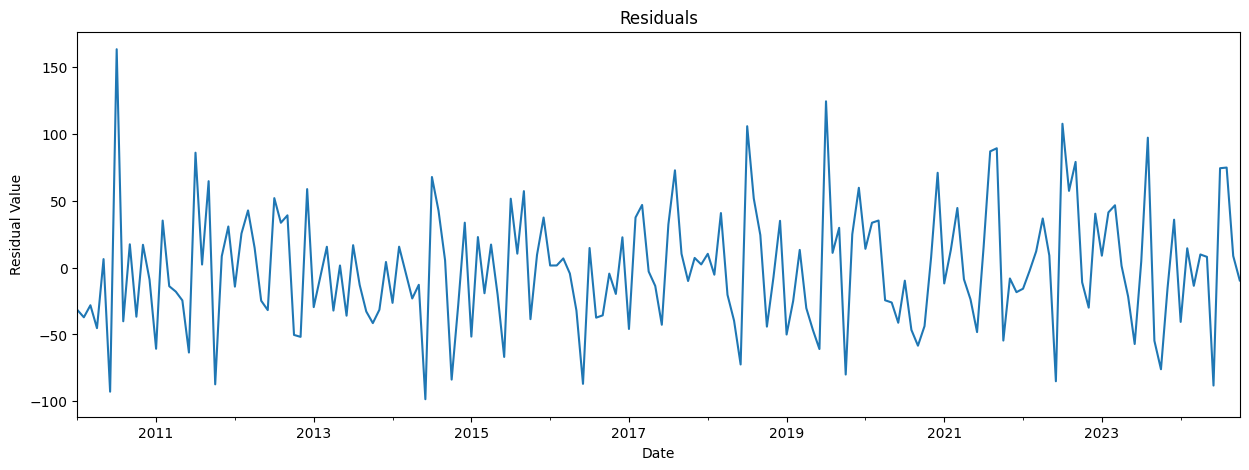

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/content/Manually edited file.csv')
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
df.set_index('Date', inplace=True)
cases_series = df['Confirmed Cases']

# Split data into train and test
train_size = int(len(cases_series) * 0.8)
train, test = cases_series[:train_size], cases_series[train_size:]

def comprehensive_arima_evaluation(train, test):
    # Parameter grid for comprehensive search
    p_range = range(0, 3)
    d_range = range(0, 2)
    q_range = range(0, 3)

    results = []

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    # Fit ARIMA model
                    model = sm.tsa.ARIMA(train, order=(p,d,q))
                    results_model = model.fit()

                    # Forecast on test set
                    forecast = results_model.forecast(steps=len(test))

                    # Compute comprehensive metrics
                    mse = mean_squared_error(test, forecast)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(test, forecast)
                    mape = mean_absolute_percentage_error(test, forecast)
                    r2 = r2_score(test, forecast)

                    results.append({
                        'Order (p,d,q)': (p,d,q),
                        'AIC': results_model.aic,
                        'BIC': results_model.bic,
                        'MSE': mse,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE (%)': mape * 100,
                        'R2 Score': r2
                    })
                except Exception as e:
                    print(f"Error with {(p,d,q)}: {e}")

    # Convert to DataFrame and sort by multiple criteria
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['RMSE', 'MAE', 'AIC'])

    return results_df

# Evaluate models
evaluation_results = comprehensive_arima_evaluation(train, test)
print("ARIMA Model Evaluation Results:")
print(evaluation_results)

# Select best model based on lowest RMSE and AIC
best_model_params = evaluation_results.iloc[0]
print("\nBest ARIMA Model Parameters:")
print(best_model_params)

# Fit best model on full dataset and forecast
best_order = tuple(best_model_params['Order (p,d,q)'])
best_model = sm.tsa.ARIMA(cases_series, order=best_order).fit()

# Forecast next 12 months with proper confidence intervals
forecast = best_model.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(cases_series.index, cases_series.values, label='Historical Data')
plt.plot(forecast_mean.index, forecast_mean.values, color='red', label='Forecast')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.tight_layout()
plt.show()

# Detailed Forecast
print("\nDetailed Forecast for Next 12 Months:")
print(forecast_mean)

# Forecast Confidence Intervals
print("\nForecast Confidence Intervals:")
print(forecast_conf_int)

# Model Diagnostics
plt.figure(figsize=(15,5))
best_model.resid.plot(title='Residuals')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.show()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.1907 - val_loss: 0.1935
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1538 - val_loss: 0.1594
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1418 - val_loss: 0.1282
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1271 - val_loss: 0.0976
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0873 - val_loss: 0.0715
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0830 - val_loss: 0.0557
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0781 - val_loss: 0.0513
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0680 - val_loss: 0.0497
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0746 - val_loss: 0.0485
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0617 - val_loss: 0.0484
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661 - val_loss: 0.0470
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0638 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal


Model Evaluation Metrics:
MSE: 3198.78
RMSE: 56.56
MAE: 41.50
R2 Score: 0.4881

Forecast for Next 12 Months:
         Date  Forecasted Cases
0  2024-11-30        196.842957
1  2024-12-31        187.084991
2  2025-01-31        186.961502
3  2025-02-28        133.903412
4  2025-03-31        133.903412
5  2025-04-30        133.903412
6  2025-05-31        133.903412
7  2025-06-30        133.903412
8  2025-07-31        133.903412
9  2025-08-31        133.903412
10 2025-09-30        133.903412
11 2025-10-31        133.903412


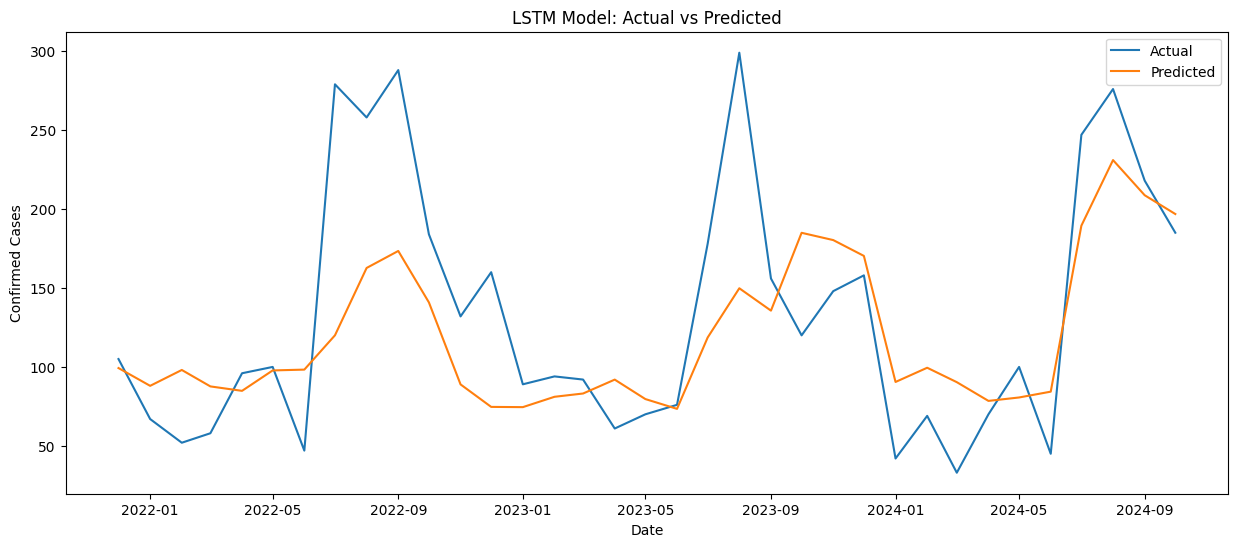

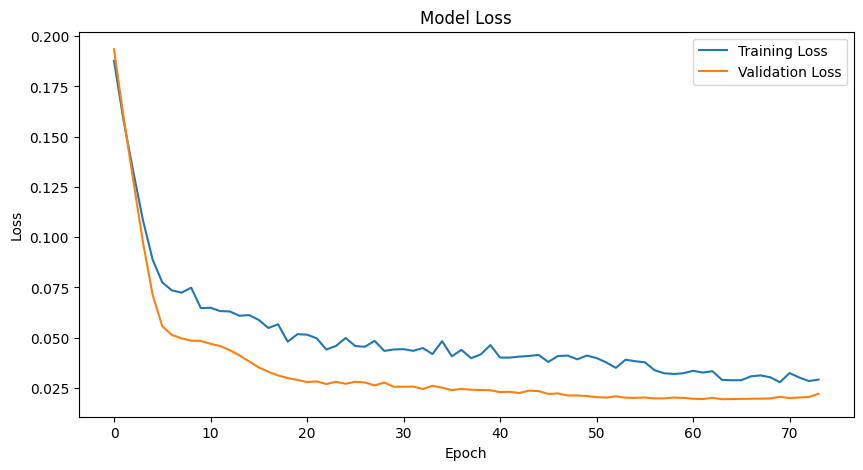

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
def load_and_preprocess_data():
    df = pd.read_csv('/content/Manually edited file.csv')
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
    df.set_index('Date', inplace=True)
    return df

# Select features for prediction
features = [
    'Temperature (°C)',
    'Rainfall (mm)',
    'Humidity (%)',
    'Wind Speed (km/h)',
    'Mosquito Distribution Index'
]
target = 'Confirmed Cases'

def prepare_lstm_data(dataset, features, target, look_back=3):
    # Normalize the data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    # Scale features and target
    scaled_features = scaler_features.fit_transform(dataset[features])
    scaled_target = scaler_target.fit_transform(dataset[[target]])

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_features) - look_back):
        X.append(scaled_features[i:i+look_back])
        y.append(scaled_target[i+look_back])

    return (
        np.array(X, dtype=np.float32),
        np.array(y, dtype=np.float32),
        scaler_features,
        scaler_target
    )

def forecast_next_months(model, last_sequences, scaler_features, scaler_target, df, features, months=12):
    # Ensure last_sequences has the correct shape (lookback, features)
    last_sequences = last_sequences[-1]  # Take just the last sequence
    current_seq = last_sequences.reshape(1, last_sequences.shape[0], last_sequences.shape[1])
    forecasts = []

    # Create a copy of the last known features for updating
    last_features = df[features].iloc[-1:].values

    for _ in range(months):
        # Make prediction
        next_pred = model.predict(current_seq, verbose=0)
        forecasts.append(scaler_target.inverse_transform(next_pred)[0][0])

        # Update the sequence - remove oldest timestep and add the new prediction
        current_seq = current_seq[:, 1:, :]  # Remove oldest timestep

        # Use the last known features (you might want to modify this based on your needs)
        next_features = last_features
        normalized_features = scaler_features.transform(next_features)

        # Add new timestep
        new_timestep = normalized_features.reshape(1, 1, len(features))
        current_seq = np.concatenate([current_seq, new_timestep], axis=1)

    return forecasts

def create_lstm_model(look_back, feature_count):
    inputs = Input(shape=(look_back, feature_count))

    # First LSTM layer
    x = LSTM(50, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.2)(x)

    # Second LSTM layer
    x = LSTM(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Dense layers
    x = Dense(25, activation='relu')(x)
    outputs = Dense(1)(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error'
    )
    return model

def plot_predictions(df, y_test_inv, y_pred_inv):
    plt.figure(figsize=(15, 6))
    plt.plot(df.index[-len(y_test_inv):], y_test_inv, label='Actual')
    plt.plot(df.index[-len(y_pred_inv):], y_pred_inv, label='Predicted')
    plt.title('LSTM Model: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def main():
    # Load data
    df = load_and_preprocess_data()

    # Prepare data
    look_back = 3
    X, y, scaler_features, scaler_target = prepare_lstm_data(df, features, target, look_back)

    # Train-test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create and train model
    model = create_lstm_model(look_back, len(features))

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_target.inverse_transform(y_pred)
    y_test_inv = scaler_target.inverse_transform(y_test)

    # Calculate metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    # Generate forecasts
    last_sequence = X[-1:]  # Take just the last sequence
    future_forecast = forecast_next_months(
        model,
        last_sequence,
        scaler_features,
        scaler_target,
        df,
        features
    )

    # Create forecast DataFrame
    forecast_dates = pd.date_range(start=df.index[-1], periods=13, freq='M')[1:]
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted Cases': future_forecast
    })

    # Print results
    print("\nModel Evaluation Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")

    print("\nForecast for Next 12 Months:")
    print(forecast_df)

    # Plot results
    plot_predictions(df, y_test_inv, y_pred_inv)
    plot_training_history(history)

    return model, forecast_df

if __name__ == "__main__":
    model, forecasts = main()

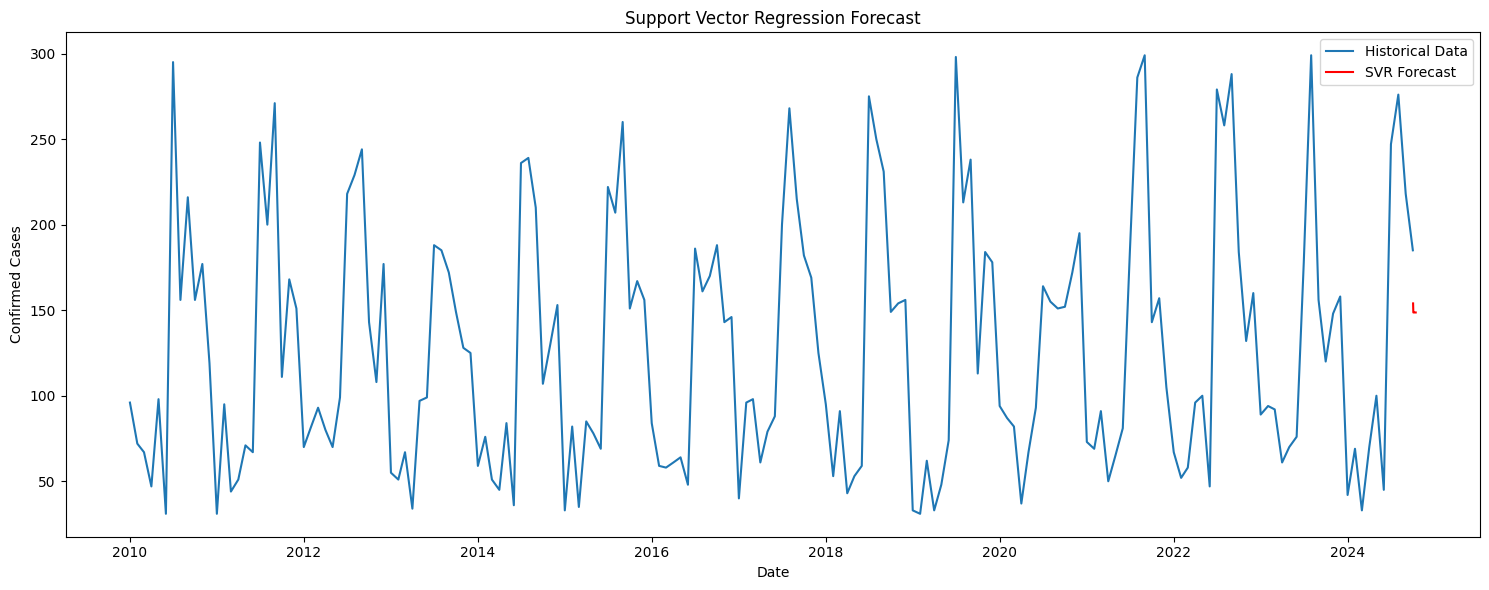


SVM Regression Results:
Best Parameters: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}

Model Performance Metrics:
MSE: 4429.690804102953
RMSE: 66.55592238188089
MAE: 46.53571652509588
MAPE (%): 40.90861052510198
R2 Score: 0.29108335915365924

SVM Forecast for Next 12 Months:
2024-10-02    153.970074
2024-10-03    148.667591
2024-10-04    148.667591
2024-10-05    148.667591
2024-10-06    148.667591
2024-10-07    148.667591
2024-10-08    148.667591
2024-10-09    148.667591
2024-10-10    148.667591
2024-10-11    148.667591
2024-10-12    148.667591
2024-10-13    148.667591
Freq: D, dtype: float64


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import GridSearchCV

def create_time_series_features(series, n_steps=3):
    """
    Create lagged features for time series forecasting

    Parameters:
    -----------
    series : pandas.Series
        Time series data
    n_steps : int, optional (default=3)
        Number of lagged steps to use as features

    Returns:
    --------
    X : numpy array of features
    y : numpy array of target values
    """
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series.values[i:i+n_steps])
        y.append(series.values[i+n_steps])
    return np.array(X), np.array(y)

def svm_time_series_forecast(df):
    """
    Perform SVM regression on time series data

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with time series data

    Returns:
    --------
    Dictionary containing model results and forecasts
    """
    # Prepare time series data
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
    df.set_index('Date', inplace=True)
    cases_series = df['Confirmed Cases']

    # Create lagged features
    X, y = create_time_series_features(cases_series)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'kernel': ['rbf', 'linear', 'poly'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.3]
    }

    # Create SVR model and GridSearchCV
    svr = SVR()
    grid_search = GridSearchCV(
        svr,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)

    # Best model
    best_svr = grid_search.best_estimator_

    # Predictions
    y_pred = best_svr.predict(X_test_scaled)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Forecast next 12 months
    full_X = scaler.transform(create_time_series_features(cases_series)[0])
    forecast_steps = 12
    forecast_data = []
    last_window = full_X[-1]

    for _ in range(forecast_steps):
        next_pred = best_svr.predict(last_window.reshape(1, -1))[0]
        forecast_data.append(next_pred)
        last_window = np.roll(last_window, -1)
        last_window[-1] = next_pred

    # Create forecast series (removed 'closed' parameter)
    last_date = cases_series.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1)[1:]
    forecast_series = pd.Series(forecast_data, index=forecast_dates)

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.plot(cases_series.index, cases_series.values, label='Historical Data')
    plt.plot(forecast_series.index, forecast_series.values, color='red', label='SVR Forecast')
    plt.title('Support Vector Regression Forecast')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return results
    return {
        'best_params': grid_search.best_params_,
        'metrics': {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape * 100,
            'R2 Score': r2
        },
        'forecast': forecast_series
    }

# Load data and run SVM forecast
df = pd.read_csv('/content/Manually edited file.csv')
svm_results = svm_time_series_forecast(df)

# Print results
print("\nSVM Regression Results:")
print("Best Parameters:", svm_results['best_params'])
print("\nModel Performance Metrics:")
for metric, value in svm_results['metrics'].items():
    print(f"{metric}: {value}")

print("\nSVM Forecast for Next 12 Months:")
print(svm_results['forecast'])

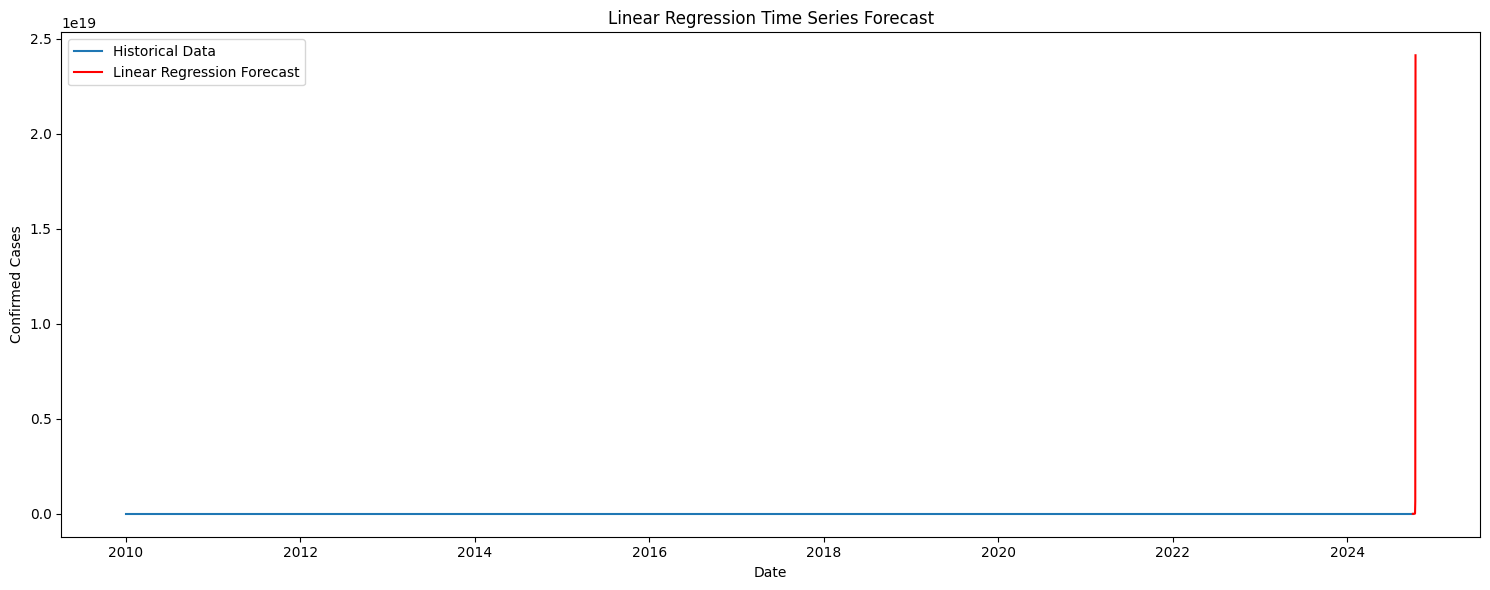

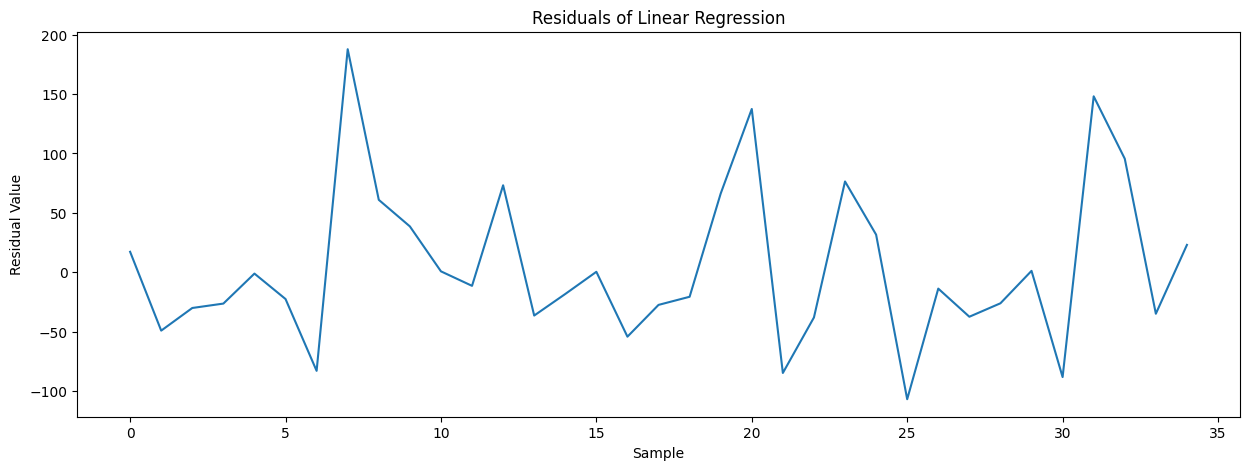


Linear Regression Results:

Model Performance Metrics:
MSE: 4470.273426048308
RMSE: 66.86010339543536
MAE: 50.54831140333509
MAPE (%): 50.12928397016429
R2 Score: 0.2845886178052133

Linear Regression Forecast for Next 12 Months:
2024-10-02    1.619529e+02
2024-10-03    5.929283e+03
2024-10-04    2.159143e+05
2024-10-05    7.855765e+06
2024-10-06    2.858192e+08
2024-10-07    1.039906e+10
2024-10-08    3.783525e+11
2024-10-09    1.376573e+13
2024-10-10    5.008433e+14
2024-10-11    1.822235e+16
2024-10-12    6.629902e+17
2024-10-13    2.412180e+19
Freq: D, dtype: float64


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

def create_time_series_features(series, n_steps=3):
    """
    Create lagged features for time series forecasting

    Parameters:
    -----------
    series : pandas.Series
        Time series data
    n_steps : int, optional (default=3)
        Number of lagged steps to use as features

    Returns:
    --------
    X : numpy array of features
    y : numpy array of target values
    """
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series.values[i:i+n_steps])
        y.append(series.values[i+n_steps])
    return np.array(X), np.array(y)

def linear_regression_time_series_forecast(df, n_steps=3):
    """
    Perform Linear Regression on time series data

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with time series data
    n_steps : int, optional (default=3)
        Number of lagged time steps to use as features

    Returns:
    --------
    Dictionary containing model results and forecasts
    """
    # Prepare time series data
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
    df.set_index('Date', inplace=True)
    cases_series = df['Confirmed Cases']

    # Create lagged features
    X, y = create_time_series_features(cases_series, n_steps)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale features
    scaler = StandardScaler()

    # Reshape X to 2D for scaling
    X_train_2d = X_train.reshape(-1, n_steps)
    X_test_2d = X_test.reshape(-1, n_steps)

    # Scale features
    X_train_scaled = scaler.fit_transform(X_train_2d).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape)

    # Flatten features for linear regression
    X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
    X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

    # Create and train Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train_flat, y_train)

    # Predictions
    y_pred = lr_model.predict(X_test_flat)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Prepare full dataset features
    full_X, _ = create_time_series_features(cases_series, n_steps)

    # Scale full features
    full_X_2d = full_X.reshape(-1, n_steps)
    full_X_scaled = scaler.transform(full_X_2d).reshape(full_X.shape)
    full_X_flat = full_X_scaled.reshape(full_X_scaled.shape[0], -1)

    # Forecast next 12 months
    forecast_steps = 12
    forecast_data = []
    last_window = full_X_scaled[-1]

    for _ in range(forecast_steps):
        # Flatten current window
        current_window_flat = last_window.reshape(1, -1)

        # Predict next value
        next_pred = lr_model.predict(current_window_flat)[0]
        forecast_data.append(next_pred)

        # Update sliding window
        last_window = np.roll(last_window, -1)
        last_window[-1] = next_pred

    # Create forecast series
    last_date = cases_series.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1)[1:]
    forecast_series = pd.Series(forecast_data, index=forecast_dates)

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.plot(cases_series.index, cases_series.values, label='Historical Data')
    plt.plot(forecast_series.index, forecast_series.values, color='red', label='Linear Regression Forecast')
    plt.title('Linear Regression Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual Analysis
    plt.figure(figsize=(15, 5))
    residuals = y_test - y_pred
    plt.plot(residuals)
    plt.title('Residuals of Linear Regression')
    plt.xlabel('Sample')
    plt.ylabel('Residual Value')
    plt.show()

    # Return results
    return {
        'model_coefficients': lr_model.coef_,
        'model_intercept': lr_model.intercept_,
        'metrics': {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape * 100,
            'R2 Score': r2
        },
        'forecast': forecast_series
    }

# Load data and run Linear Regression forecast
df = pd.read_csv('/content/Manually edited file.csv')
lr_results = linear_regression_time_series_forecast(df)

# Print results
print("\nLinear Regression Results:")
print("\nModel Performance Metrics:")
for metric, value in lr_results['metrics'].items():
    print(f"{metric}: {value}")

print("\nLinear Regression Forecast for Next 12 Months:")
print(lr_results['forecast'])

Data Diagnostics:
Total data points: 178
NaN values: 0
Data range: 31 to 299

Descriptive Statistics:
count    178.000000
mean     127.387640
std       72.620531
min       31.000000
25%       67.500000
50%      100.000000
75%      177.000000
max      299.000000
Name: Confirmed Cases, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Forecast Performance Metrics:
Mean Squared Error (MSE): 1152.955046282172
Root Mean Squared Error (RMSE): 33.955191742680114
Mean Absolute Error (MAE): 27.025188945487205
R-squared (R2) Score: 0.8107002595463288


<ipython-input-7-24f31f10b2ff>:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_forecast_index = pd.date_range(start=future_forecast_start, periods=len(future_forecast), freq='M')


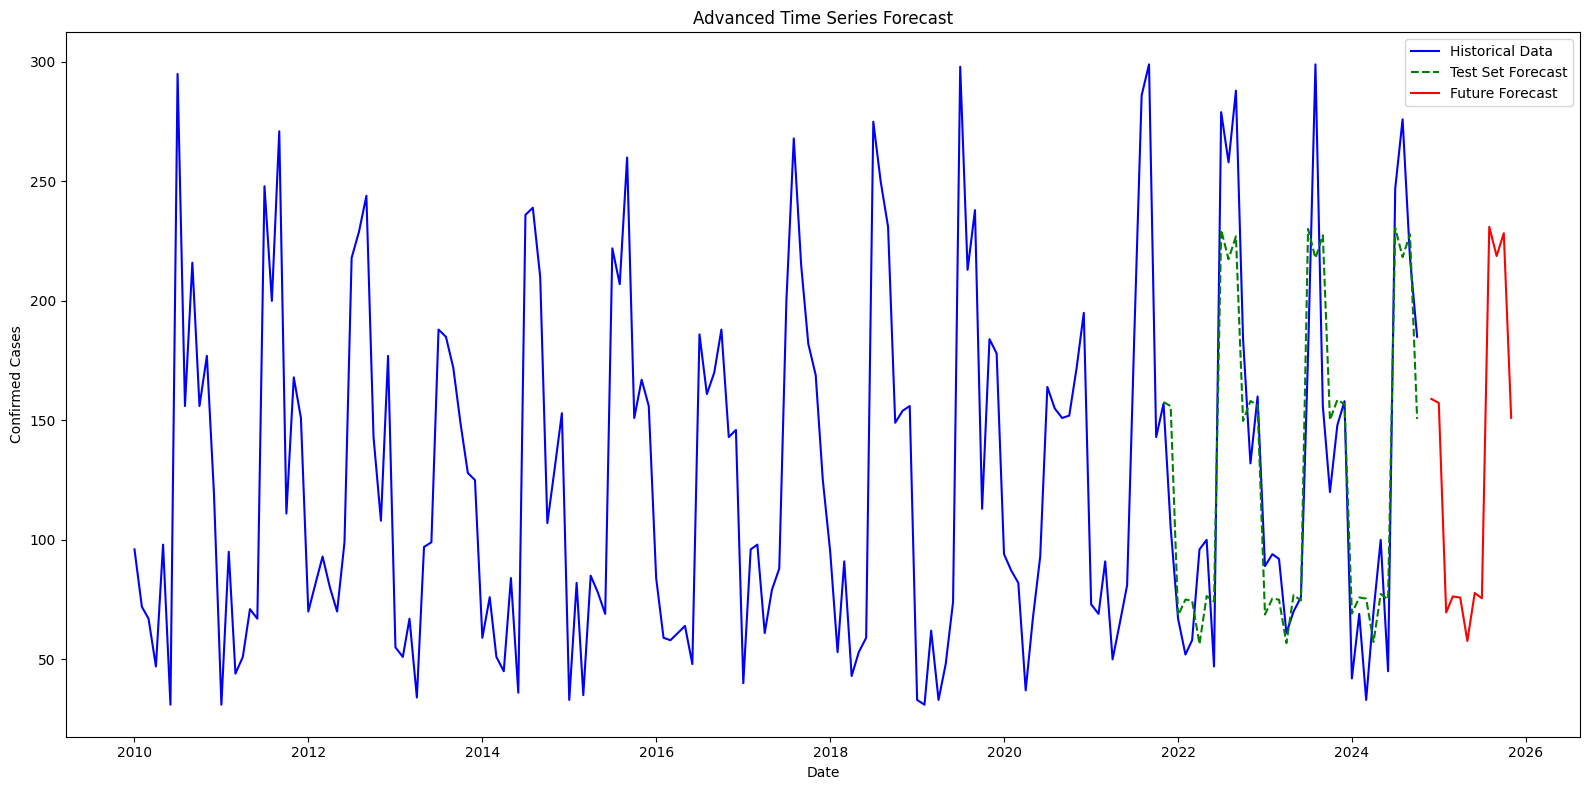

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def advanced_time_series_forecast(df):
    """
    Perform robust time series forecasting with comprehensive metrics and diagnostics

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with time series data

    Returns:
    --------
    Dictionary containing forecast results and metrics
    """
    # Convert month names to numbers
    month_mapping = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }

    # Verify Month column and convert
    if df['Month'].dtype == object:
        # Convert month names to numbers
        df['Month'] = df['Month'].map(month_mapping)

    # Prepare time series data
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
    df.sort_values('Date', inplace=True)

    # Reset index to use Date as index
    df.set_index('Date', inplace=True)

    # Verify data
    cases_series = df['Confirmed Cases']

    # Comprehensive data diagnostics
    print("Data Diagnostics:")
    print(f"Total data points: {len(cases_series)}")
    print(f"NaN values: {cases_series.isna().sum()}")
    print(f"Data range: {cases_series.min()} to {cases_series.max()}")
    print("\nDescriptive Statistics:")
    print(cases_series.describe())

    # Handle NaN values
    if cases_series.isna().sum() > 0:
        # Interpolate missing values
        cases_series = cases_series.interpolate()

    # Ensure continuous time series
    if pd.infer_freq(cases_series.index) is None:
        cases_series = cases_series.resample('M').mean()

    # Split data
    train_size = int(len(cases_series) * 0.8)
    train, test = cases_series[:train_size], cases_series[train_size:]

    # Enhanced Seasonal Exponential Smoothing
    try:
        model = ExponentialSmoothing(
            train,
            seasonal_periods=12,  # yearly seasonality for monthly data
            trend='add',
            seasonal='add',
            initialization_method='estimated'
        )

        # Fit the model
        fitted_model = model.fit()

        # Forecasting
        forecast_steps = len(test) + 12
        forecast = fitted_model.forecast(steps=forecast_steps)

        # Performance metrics
        test_forecast = forecast[:len(test)]

        # Compute metrics
        metrics = {
            'Mean Squared Error (MSE)': mean_squared_error(test, test_forecast),
            'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(test, test_forecast)),
            'Mean Absolute Error (MAE)': mean_absolute_error(test, test_forecast),
            'R-squared (R2) Score': r2_score(test, test_forecast)
        }

        # Print metrics
        print("\nForecast Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

        # Visualization
        plt.figure(figsize=(16, 8))

        # Plot historical data
        plt.plot(cases_series.index, cases_series.values, label='Historical Data', color='blue')

        # Plot test set forecast
        plt.plot(test.index, test_forecast, label='Test Set Forecast', color='green', linestyle='--')

        # Plot future forecast
        future_forecast_start = cases_series.index[-1] + pd.DateOffset(months=1)
        future_forecast = forecast[len(test):]
        future_forecast_index = pd.date_range(start=future_forecast_start, periods=len(future_forecast), freq='M')
        plt.plot(future_forecast_index, future_forecast, label='Future Forecast', color='red')

        plt.title('Advanced Time Series Forecast')
        plt.xlabel('Date')
        plt.ylabel('Confirmed Cases')
        plt.legend()
        plt.tight_layout()
        plt.show()

        return {
            'metrics': metrics,
            'test_forecast': test_forecast,
            'future_forecast': pd.Series(future_forecast, index=future_forecast_index)
        }

    except Exception as e:
        print(f"Forecasting failed with error: {e}")
        return None

# Load and forecast
df = pd.read_csv('/content/Manually edited file.csv')
results = advanced_time_series_forecast(df)